In [1]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct")

In [2]:
## Document Ingestion And Processing
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header") #typical webscraping from these type of classes
        )
    ),
)
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [4]:
## chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [6]:
## Vector Store

from langchain_community.vectorstores import FAISS
vector_store=FAISS.from_documents(
    documents=all_splits,
    embedding=embeddings
)
print(f"Vector store created with {vector_store.index.ntotal} vectors")

Vector store created with 63 vectors


In [8]:
from langchain_core.tools import tool
@tool()
def retrieve(query:str):
    """Retrieve the information related to the query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [11]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [12]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'retrieve': StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x1368a1080>)}, _injected_args={'retrieve': _InjectedArgs(state={}, store=None, runtime=None)}, _handle_tool_errors=<function _default_handle_tool_errors at 0x13667ff60>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)

In [13]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

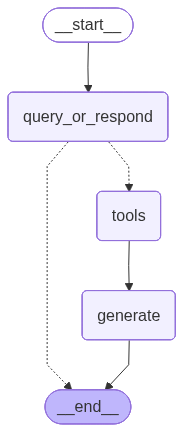

In [15]:
# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver() # this is where the persistent memory thing happens
graph = graph_builder.compile(checkpointer=memory) 
graph

In [16]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "1"}}

In [17]:
input_message="Hello"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [18]:
vector_store.similarity_search("What is Task Decomposition")

[Document(id='ad87a5a2-1cf5-4041-81f8-ef46447a67c7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [19]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is a process of breaking down a complex task into smaller, more manageable sub-tasks. It involves identifying the individual components or steps required to complete a task, and then organizing them in a logical and sequential manner.

Task decomposition is often used in various fields, including:

1. Project management: to break down large projects into smaller, more manageable tasks
2. Artificial intelligence: to decompose complex tasks into simpler sub-tasks that can be executed by machines
3. Cognitive psychology: to understand how people process information and perform tasks
4. Business process improvement: to identify inefficiencies and improve workflows

The benefits of task decomposition include:

1. Improved clarity and understanding of the task
2. Enhanced productivity

In [20]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (aes14470a)
 Call ID: aes14470a
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to d

In [21]:
# Conversation History
chat_history=graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is a process of breaking down a complex task into smaller, more manageable sub-tasks. It involves identifying the individual components or steps required to complete a task, and then organizing them in a logical and sequential manner.

Task decomposition is often used in various fields, including:

1. Project management: to break down large projects into smaller, more manageable tasks
2. Artificial intelligence: to decompose complex tasks into simpler sub-tasks that can be executed by machines
3. Cognitive psychology: to understand how people process information and perform tas

## ReAct Agent Architecture

In [22]:
retrieve

StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x1368a1080>)

In [23]:
from langgraph.prebuilt import create_react_agent
memory = MemorySaver()
agent_executor=create_react_agent(llm,[retrieve],checkpointer=memory)

/var/folders/qt/64kxbqr16ps6hbrf1lzxq5dc0000gn/T/ipykernel_66691/2567764399.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor=create_react_agent(llm,[retrieve],checkpointer=memory)


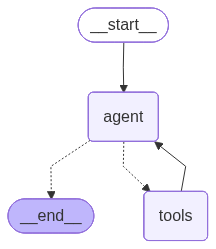

In [24]:
agent_executor

In [25]:
config = {"configurable": {"thread_id": "def2"}}

In [26]:
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)
for event in agent_executor.stream({"messages": [{"role": "user", "content": input_message}]},
                                   stream_mode="values",
                                   config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

Task decomposition is a process of breaking down a complex task into smaller, more manageable sub-tasks. The standard method for task decomposition involves several steps:

1. **Define the task**: Clearly articulate the task that needs to be accomplished.
2. **Identify the goal**: Determine the objective of the task and what needs to be achieved.
3. **Brainstorm sub-tasks**: Break down the task into smaller sub-tasks that need to be completed to achieve the goal.
4. **Analyze sub-tasks**: Evaluate each sub-task to determine its complexity, dependencies, and required resources.
5. **Organize sub-tasks**: Arrange the sub-tasks in a logical order, taking into account dependencies and prerequisites.
6. **Assign